In [2]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
from netCDF4 import Dataset
import multiprocessing
from numba import jit
import scipy
from histogram import histogram, percentile_from_histogram, value_from_histogram

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})

From previous testing, the inclusion of supplemental locations in quantile mapping induces modest improvements in the bias from the analysis, but more significant is the large decrease in forecast skill for some locations. 

I am sure the performance of the supplemental locations can be improved by cherry picking the best locations (instead of just using all 50). In Hamill+2017 (the NBM paper) they use only the SLs with a penalty value below some number (in their case, it was $\Delta$ = 0.3 but that obviously depends on the choice of penalty weights, etc.), which is an easy test. We could also use the Pearson correlations similarly, though this would  of course select the "best" locations based on climotology alone, which could be risky given that the penalty function weighs differences in terrain higher than differences in climotology. 

Other tests will neccesitate changing the actual SL algorithm: one idea is to just simply weight the climotology higher than the terrain. The other is to keep the overall weights the same but change the internal weighting of the percentiles used to quantify the difference in climotologies. In essence, the precipitation CDF penalty function can be reworked to put heavier weight on top percentiles of precipitation, with the reasoning of it’s more important to match extreme/significant precip events than it is to match small amounts

Below, will look into (1) selecting only the "best" SLs from the limit_water_v4 model run, (2) editing the SL code to put more power in the 75th and above percentiles (for instance, 75th percentile and above get multiplied by 1.5) and, (3) again editing teh SL to increase the overall weight of the precipitation penalty.


## utils

In [2]:
from nimbl import stations  #.from_mos2ktbl

#selected stations for analysis
station_data = '//scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/common/mdl_station.tbl'
station_points = stations.from_mos2ktbl(station_data, ['KSEA','KMSP','KBOS', 'KLAS','KLIT','KMCO', 'KDEN', 'KCVG'])

#rename weird ones
st_names = station_points['name'].copy()
st_names[3] = 'Las Vegas'
st_names[6] = 'Denver'
st_names[8] = 'Cincinnati'

In [3]:
#get CONUS lat/lons
ds = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/blend.supplemental_locations_4.co.2p5.nc',
             mode="r")

#unpack lats and lons to index over
lat_arr = ds.latitude.data
lon_arr = ds.longitude.data
ds.close()

In [4]:
def get_nearest_grid(lat_input, long_input):
    # Get indices of the nearest lat/lon values
    # Lat/long input will be values corresponding to chosen stations
    lat_index, lon_index = [],[]


    for i in range(len(lat_input)):
        a = np.abs(lat_arr-lat_input[i]) + np.abs(lon_arr-long_input[i])
        i,j = np.unravel_index(a.argmin(), a.shape)
        lat_index.append(i)
        lon_index.append(j)
    return lat_index, lon_index

def to360(x):
    return (x - 180) % 360 + 180

In [5]:
station_lats = station_points['lat']
station_lons = to360(station_points['lon']) #need to convert from E/W to 0-360

station_lat_idx, station_lon_idx = get_nearest_grid(station_lats, station_lons)

conus_gp = (station_lat_idx, station_lon_idx)

In [3]:
def convert_datetime64_to_datetime( usert: np.datetime64 )->datetime.datetime:
    t = np.datetime64( usert, 'us').astype(datetime.datetime)
    return t

#first, get CONUS grid info
from nimbl.metadata import get_metadata
import grib2io

conus_grid_def = get_metadata('grib2_section3', model='blend',region='co' )
conus_grid_grib2 = grib2io.Grib2GridDef(conus_grid_def[4], conus_grid_def[5:])

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/nimbl/metadata/metadata.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metadata_df = pd.concat(collect, axis="index")


# Compare bias across all models

In [128]:
no_sl = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/higher_weight_climo//month_bias_without_sl.zarr')

default = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/month_bias_with_sl.zarr')
default20 = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/month_bias_with_20sl.zarr')
climo_over_terrain = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/higher_weight_climo//month_bias_with_sl.zarr')
top_climo_percentiles = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/weight_climo_percentiles//month_bias_with_sl.zarr')

In [103]:
no_sl

<xarray.Dataset> Size: 260kB
Dimensions:    (month: 4, day: 30, station: 9, locations: 30)
Coordinates:
  * day        (day) int64 240B 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
  * locations  (locations) int64 240B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29
  * month      (month) int64 32B 1 4 7 11
  * station    (station) object 72B 'SEATTLE-TACOMA' ... 'Cincinnati'
Data variables:
    bias       (month, day, station, locations) float64 259kB ...

In [16]:
models = [no_sl, default, default20, climo_over_terrain, top_climo_percentiles]
model_names = ['No SLs', 'Default', 'Default 20', 'Larger Climo Weight', 'Top Percentiles']


Text(0.045, 0.07, 'Bias (Forecast - Analysis)')

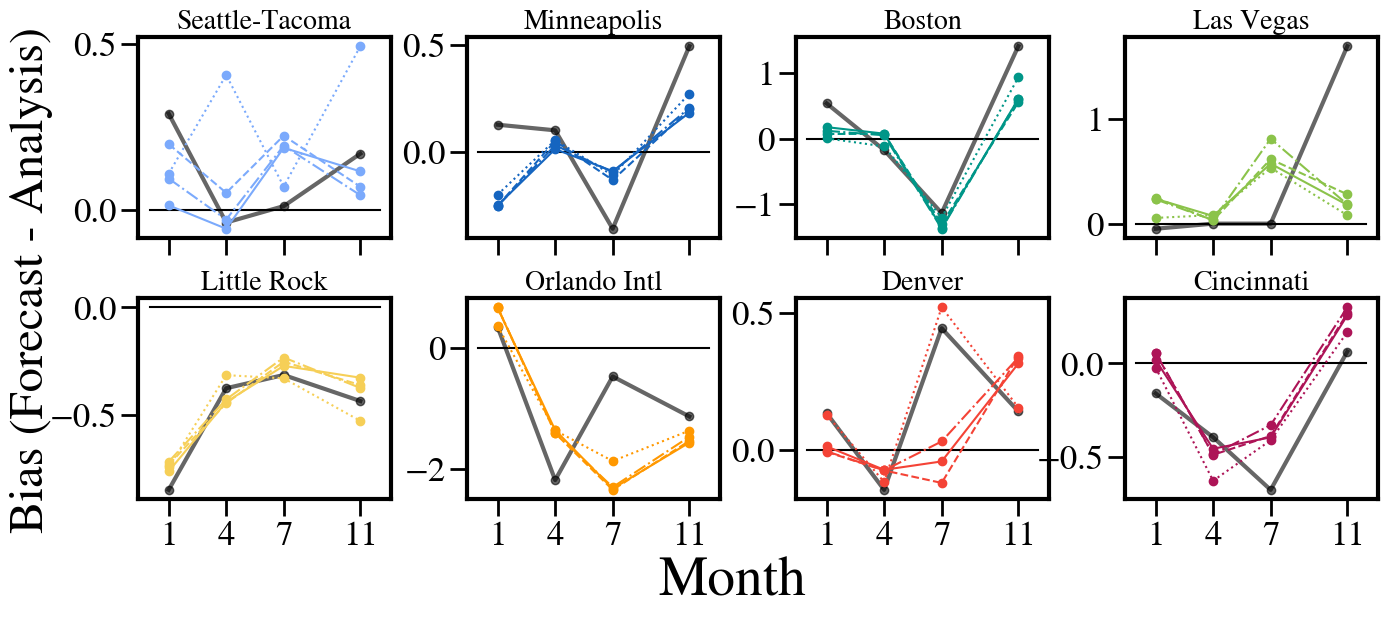

In [130]:
fig, axes = plt.subplots(2,4, sharex=True, figsize=(16, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#axes[0,0].set_ylim([-.05, 0.1])
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        axes[i,j].plot([0,12], [0,0], color='black')
        axes[i,j].set_title(st_names[stat].title(), fontsize=20)
        for model in range(len(models)):
            dat = models[model].bias.mean(dim='day').mean(dim='locations').data
            if model == 0:
                axes[i,j].plot(months, dat[:,stat], lw=3, marker='o', color='black',alpha=0.6,label=model_names[model])
            elif model == 1:
                axes[i,j].plot(months, dat[:,stat], color=colors[stat], lw=1.5, marker='o',label=model_names[model])
            elif model == 2:
                axes[i,j].plot(months, dat[:,stat], color=colors[stat], lw=1.5,ls=':' ,marker='o',label=model_names[model])
            elif model == 3:
                axes[i,j].plot(months, dat[:,stat], color=colors[stat], lw=1.5,ls='--', marker='o',label=model_names[model])
            elif model == 4:
                axes[i,j].plot(months, dat[:,stat], color=colors[stat], lw=1.5,ls='dashdot', marker='o',label=model_names[model])


#axes[0,0].legend(frameon=False, loc='upper left', ncol=2)
axes[0,0].set_xticks(months)
fig.text(x=0.45, y=-0.05, s='Month', fontdict={'fontsize': 40})
fig.text(x=0.045, y=0.07, s=f'Bias (Forecast - Analysis)', rotation='vertical',fontdict={'fontsize': 35})

# Full CONUS

--Ok I think we do need to do an actual analysis on the full CONUS grid. Obviously from above, a month's average is a bit too ambitious. But I think we can handle calculating just a single 6h precip forecast bias if we just use the previous 30 days' worth of data.--

OK STILL doesn't work. I underestimate the data load of CONUS each time. New idea then: just pick ~100 random CONUS locations (+ above stations) and make monthly bias plots from that. 

In [45]:
conus_sample = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/conus_grid_sample_points.zarr', engine='zarr')
lat_idx = conus_sample.latitude_idx.data
lon_idx = conus_sample.longitude_idx.data

{230.0: ([<matplotlib.lines.Line2D at 0x14fecb3710f0>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x14fecb371360>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x14fecb371600>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x14fecb3718a0>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x14fecb371b40>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x14fecb371de0>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x14fecb372080>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x14fecb372320>], [])}

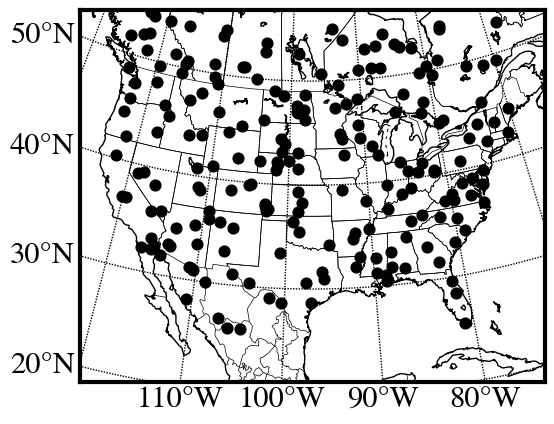

In [35]:
fig, axes = plt.subplots(1,1, figsize=(6,6))

m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')

x, y = m(lon_arr[lat_idx, lon_idx], lat_arr[lat_idx, lon_idx])  # transform coordinates
plt.scatter(x, y, s=60, color='black')

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

In [46]:
valid_models = ['limit_water_v4', 'weight_climo_percentiles', 'higher_weight_climo']

In [49]:
months = [1, 4, 7, 11]

sl_model = valid_models[0]
num_sls = 50
precip_amount = 1. #amount to calculate the Brier score w.r.t

monthly_bias_sl = np.zeros((len(months), 30, len(lat_idx), 30*num_sls)) #month, day, station, (50 SLs per member)-analysis
monthly_bias = np.zeros((len(months), 30, len(lat_idx), 30))

brier_with_sl = np.zeros((len(months), 30, len(lat_idx)))
brier_without_sl = np.zeros((len(months), 30, len(lat_idx)))

bins = np.logspace(np.log10(0.254), 1.5, 50)
bins = np.insert(bins, 0, 0.)

for month in months:
    print(f"Starting {datetime.date(2023,month,1).strftime('%B')}")

    day_count = 0
    for day_of_month in tqdm(range(30,0,-1)):
        start_day = datetime.date(2023,month,day_of_month) 
    
        ### Load data ###
        hist_dir = f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/{sl_model}/urma_histograms/{month}/'
        urma_precip_da = xr.open_dataarray(hist_dir+f'/precip_{start_day.strftime("%Y%m%d")}_CONUS.zarr',
                                   engine='zarr')
        hist_dir = f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/{sl_model}/gefs_histograms/{month}/'
        gefs_precip_da = xr.open_dataarray(hist_dir+f'/precip_{start_day.strftime("%Y%m%d")}_CONUS.zarr',
                                   engine='zarr')

    
        ### construct 60 day CDFs ###
        urma_hist = histogram(urma_precip_da, bins)
        gefs_hist = histogram(gefs_precip_da, bins)
    
        ### Quantile Mapping ###
        p_with_sl = percentile_from_histogram(gefs_hist.sum(dim='member').sum(dim='location'), gefs_precip_da)
        v_with_sl = value_from_histogram(urma_hist.sum(dim='location'), p_with_sl)
        v_with_sl = np.where(v_with_sl<0.254, 0., v_with_sl)
    
        p = percentile_from_histogram(gefs_hist.sum(dim='member').sel(location=0), gefs_precip_da[:,:,:,0])
        v = value_from_histogram(urma_hist.sel(location=0), p)
        v = np.where(v<0.254, 0., v)
    
        ### Load analysis ###
        #when is GEFS data valid
        temp = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{start_day.strftime("%Y%m%d")}/gefs01.t0z.f96',
                              engine='grib2io')
        dt = convert_datetime64_to_datetime(temp.validDate.data).strftime("%Y%m%d")
        temp.close()
        #print("    Loading Analysis")
        a = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/supplemental_locations_QMD/{dt}/urma2p5.{dt}00.pcp_06h.wexp.grb2',
                       engine='grib2io')
        a_at_stations = a.APCP.data[lat_idx, lon_idx]
        #print("    Calculating bias")
        for stat in range(len(lat_idx)):
            analysis_precip = a_at_stations[stat]
            if analysis_precip < 0.254:
                analysis_precip = 0.0
    
            ### Bias
            monthly_bias_sl[months.index(month), day_count, stat, :] = np.ravel(v_with_sl[stat, 0,:,:num_sls])-analysis_precip
            monthly_bias[months.index(month), day_count, stat, :] = np.ravel(v[stat, 0,:])-analysis_precip
    
            ### Brier Score
    
            # WITH SL 
            qm_sl_values = np.ravel(v_with_sl[stat, 0,:,:num_sls])
            binary_forecast = np.where(qm_sl_values > precip_amount, 1., qm_sl_values)
            binary_forecast = np.where(binary_forecast != 1., 0., binary_forecast)
            prob_at_station_sl = np.sum(binary_forecast) / len(binary_forecast)
        
            # WITHOUT SL
            qm_values = np.ravel(v[stat, 0,:])
            binary_forecast = np.where(qm_values > precip_amount, 1., qm_values)
            binary_forecast = np.where(binary_forecast != 1., 0., binary_forecast)
            prob_at_station = np.sum(binary_forecast) / len(binary_forecast)
    
            if analysis_precip > precip_amount:
                observed_at_station = 1.
            else:
                observed_at_station = 0.0
            
            brier_with_sl[months.index(month), day_count, stat] = (prob_at_station_sl - observed_at_station)**2
            
            brier_without_sl[months.index(month), day_count, stat] = (prob_at_station - observed_at_station)**2
        
        day_count += 1
    
    

Starting January


  0%|          | 0/30 [00:00<?, ?it/s]


KeyboardInterrupt



In [110]:
bias_with_sl = xr.DataArray(data=monthly_bias_sl, dims=['month', 'day', 'grid_point', 'locations'], 
                               coords=dict(month=months, day=np.arange(30), grid_point=np.arange(len(lat_idx)), locations=np.arange(num_sls*30)),
                              name='bias')

bias = xr.DataArray(data=monthly_bias, dims=['month', 'day', 'grid_point', 'locations'], 
                               coords=dict(month=months, day=np.arange(30), grid_point=np.arange(len(lat_idx)), locations=np.arange(30)),
                              name='bias')

In [111]:
bias_with_sl.to_zarr(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/{sl_model}//month_bias_with_sl_CONUS.zarr', mode='w')
bias.to_zarr(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/{sl_model}//month_bias_without_sl_CONUS.zarr', mode='w')

In [56]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

{230.0: ([<matplotlib.lines.Line2D at 0x14febb7841c0>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x14febb784430>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x14febb7846d0>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x14febb784970>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x14febb784c10>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x14febb784eb0>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x14febb785150>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x14febb7853f0>], [])}

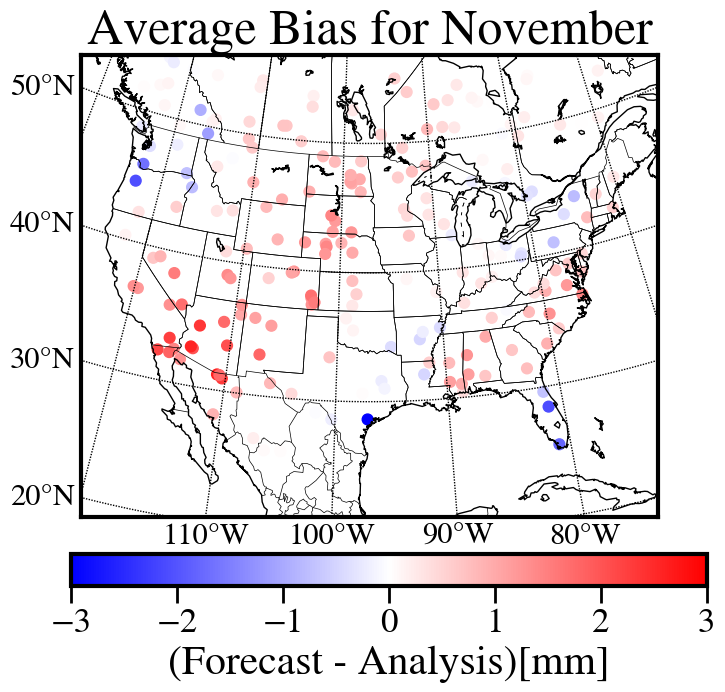

In [89]:
fig, axes = plt.subplots(1,1, figsize=(10,6))

m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')

x, y = m(lon_arr[lat_idx, lon_idx], lat_arr[lat_idx, lon_idx])  # transform coordinates

month = 3
normalize = matplotlib.colors.Normalize(vmin=-3, vmax=3)
cmap = plt.cm.bwr
mn = bias_with_sl.mean(dim='day').mean('locations')
sc = plt.scatter(x, y, s=60, c=mn[month], cmap=cmap, norm=normalize)

cbar_ax = inset_axes(axes,
                    width="110%",  # width = 50% of parent_bbox width
                    height="7%",  # height : 5%
                    loc='upper left',
                     bbox_to_anchor=(-0.04, -1.05, 1, 1),
                     bbox_transform=axes.transAxes)

cbar=plt.colorbar(sc,orientation='horizontal', cax=cbar_ax)
cbar.set_label('(Forecast - Analysis)[mm]')


axes.set_title(f"Average Bias for {datetime.date(2023,months[month],1).strftime('%B')}")

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

In [94]:
full_grid_mean_sl = bias_with_sl.mean(dim='day').mean('locations').mean(dim='grid_point')
full_grid_mean = bias.mean(dim='day').mean('locations').mean(dim='grid_point')

In [13]:
no_sl = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4//month_bias_without_sl_CONUS.zarr')

default = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/month_bias_with_sl_CONUS.zarr')
default20 = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/month_bias_with_20sl_CONUS.zarr')
#climo_over_terrain = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/higher_weight_climo//month_bias_with_sl_CONUS.zarr')
#top_climo_percentiles = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/weight_climo_percentiles//month_bias_with_sl_CONUS.zarr')

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [22]:
no_sl

<xarray.Dataset> Size: 6MB
Dimensions:     (month: 4, day: 30, grid_point: 209, locations: 30)
Coordinates:
  * day         (day) int64 240B 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29
  * grid_point  (grid_point) int64 2kB 0 1 2 3 4 5 6 ... 203 204 205 206 207 208
  * locations   (locations) int64 240B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29
  * month       (month) int64 32B 1 4 7 11
Data variables:
    bias        (month, day, grid_point, locations) float64 6MB ...

In [7]:
conus_sample = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/conus_grid_sample_points.zarr', engine='zarr')
lat_idx = conus_sample.latitude_idx.data
lon_idx = conus_sample.longitude_idx.data

In [8]:
consts = xr.open_dataset('/scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/precip/blend.precip_const.co.2p5.nc')

In [9]:
consts

<xarray.Dataset> Size: 322MB
Dimensions:               (ya: 1597, xa: 2345, ngds_grib2: 200,
                           smooth_radius: 5, ngds_tdlpack: 12)
Coordinates:
    latitude              (ya, xa) float32 15MB ...
    longitude             (ya, xa) float32 15MB ...
  * smooth_radius         (smooth_radius) int32 20B 1 5 10 20 40
  * xa                    (xa) float32 9kB 0.0 2.54e+03 ... 5.951e+06 5.953e+06
  * ya                    (ya) float32 6kB 0.0 2.54e+03 ... 4.051e+06 4.053e+06
Dimensions without coordinates: ngds_grib2, ngds_tdlpack
Data variables: (12/15)
    analysis_source_mask  (ya, xa) float32 15MB ...
    conuslandmask         (ya, xa) float32 15MB ...
    greatlakes_mask       (ya, xa) float32 15MB ...
    grib2_gds             (ngds_grib2) int32 800B ...
    land_proximity        (ya, xa) float32 15MB ...
    landmask              (ya, xa) float32 15MB ...
    ...                    ...
    terrain_facets        (smooth_radius, ya, xa) float32 75MB ...
    terrain_smoothed      (smooth_radius, ya, xa) float32 75MB ...
    validmask             (ya, xa) float32 15MB ...
    validmask_capa        (ya, xa) int16 7MB ...
    validmask_ccpa        (ya, xa) int16 7MB ...
    validmask_cmorph      (ya, xa) int16 7MB ...
Attributes:
    title:        Masks and Terrain for Blend Precip Quantile Mapping
    Conventions:  CF-1.6
    institution:  ESRL/PSD NWS/MDL
    domain:       co

In [11]:
terrain_heights = consts.terrain.data

Text(0.5, 0, 'Terrain Height [m]')

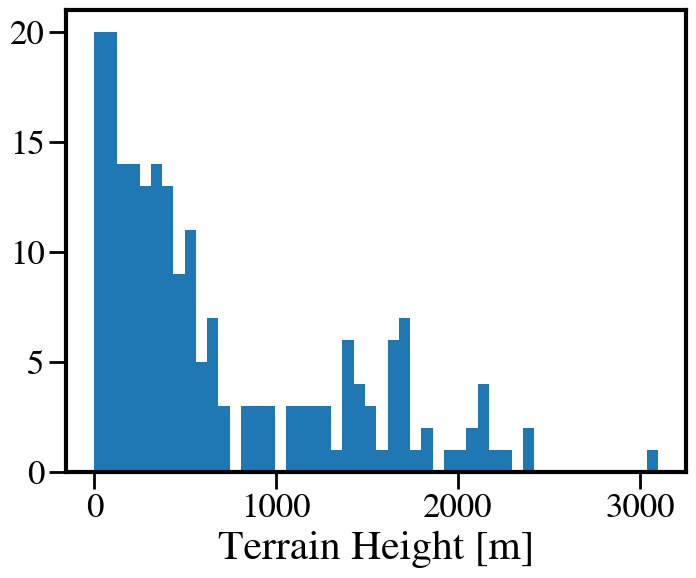

In [18]:
plt.hist(terrain_heights[lat_idx, lon_idx], range=(0,3100), bins=50)
plt.xlabel('Terrain Height [m]')

In [14]:
models = [no_sl, default, default20, ]#climo_over_terrain, top_climo_percentiles]
model_names = ['No SLs', 'Default', 'Default 20', 'Larger Climo Weight', 'Top Percentiles']
months = [1,4,7,11]

Text(0.5, 1.0, 'CONUS Sample')

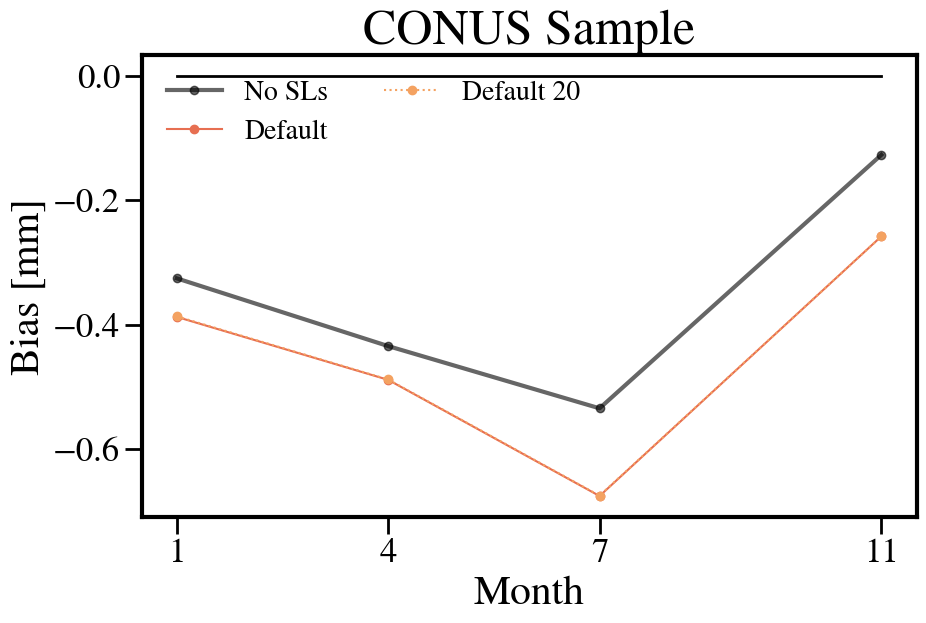

In [15]:
fig, axes = plt.subplots(1,1, sharex=True, figsize=(10, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#axes[0,0].set_ylim([-.05, 0.1])

for model in range(len(models)):
    dat = models[model].bias.mean(dim='day').mean(dim='grid_point').mean(dim='locations')
    if model == 0:
        axes.plot(months, dat, lw=3, marker='o', color='black',alpha=0.6,label=model_names[model])
    elif model == 1:
        axes.plot(months, dat, color='#E76F51', lw=1.5, marker='o',label=model_names[model])
    elif model == 2:
        axes.plot(months, dat, color='#F4A261', lw=1.5,ls=':' ,marker='o',label=model_names[model])
    elif model == 3:
        axes.plot(months, dat, color='#E9C46A', lw=1.5,ls='--', marker='o',label=model_names[model])
    elif model == 4:
        axes.plot(months, dat, color='#2A9D8F', lw=1.5,ls='dashdot', marker='o',label=model_names[model])

axes.plot([1,11], [0,0], color='black', zorder=0, lw=2)
axes.legend(frameon=False, loc='upper left', ncol=2)
axes.set_xticks(months)
#fig.text(x=0.45, y=-0.05, s='Month', fontdict={'fontsize': 40})
#fig.text(x=0.045, y=0.07, s=f'Bias (Forecast - Analysis)', rotation='vertical',fontdict={'fontsize': 35})

axes.set_ylabel('Bias [mm]')
axes.set_xlabel('Month')
axes.set_title("CONUS Sample")

In [59]:
no_sl

<xarray.Dataset> Size: 6MB
Dimensions:     (month: 4, day: 30, grid_point: 209, locations: 30)
Coordinates:
  * day         (day) int64 240B 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29
  * grid_point  (grid_point) int64 2kB 0 1 2 3 4 5 6 ... 203 204 205 206 207 208
  * locations   (locations) int64 240B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29
  * month       (month) int64 32B 1 4 7 11
Data variables:
    bias        (month, day, grid_point, locations) float64 6MB 0.0 0.0 ... 0.0

In [62]:
np.shape(no_sl.bias.mean(dim='day').mean(dim='locations').data)

(4, 209)

Text(0.5, 0, 'Terrain Height [m]')

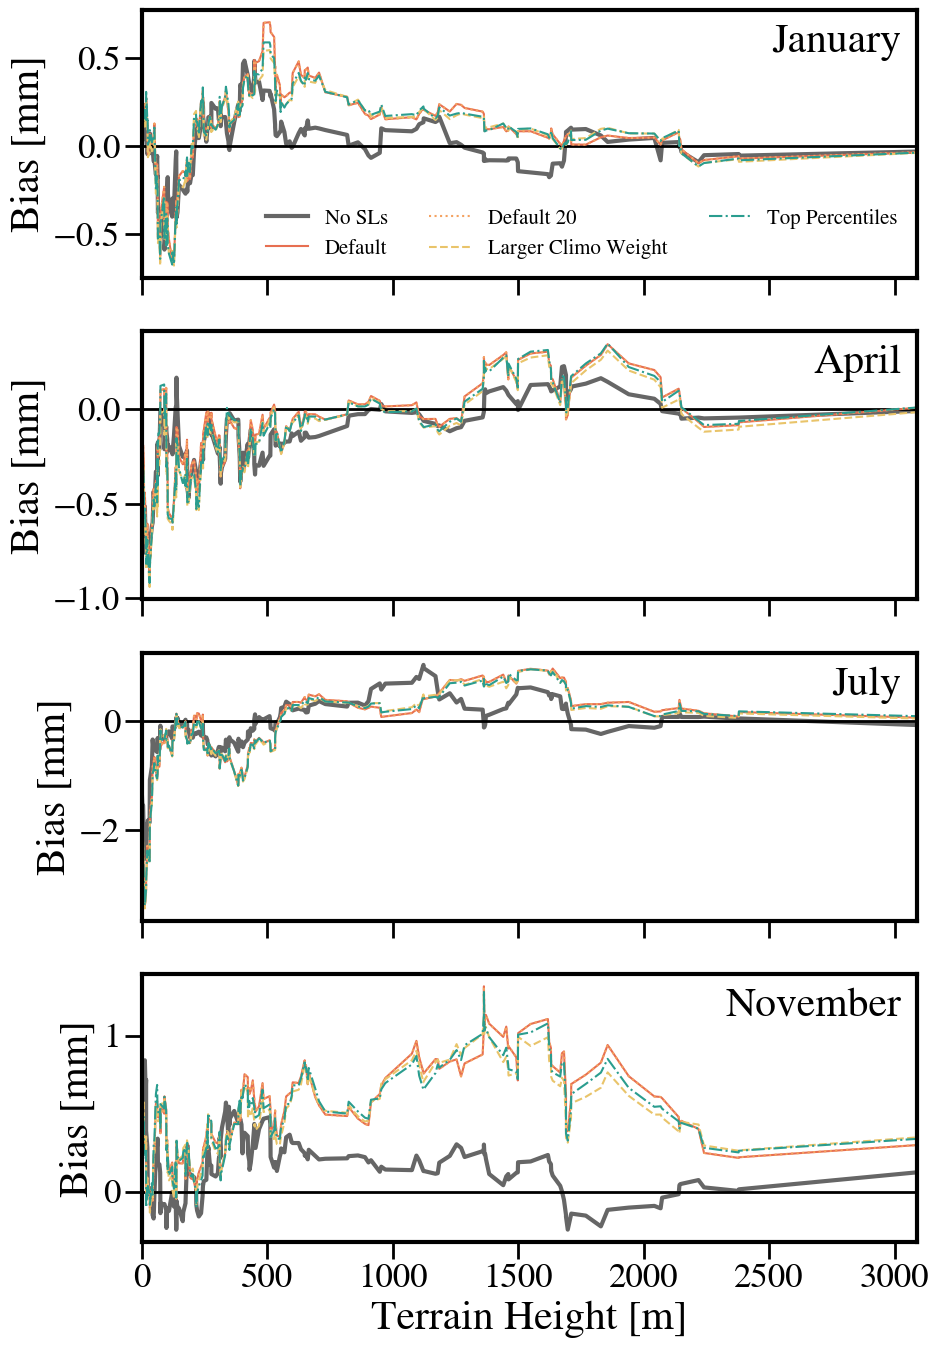

In [202]:
fig, axes = plt.subplots(4,1, sharex=True, figsize=(10, 16))
#plt.subplots_adjust(hspace=0.3, wspace=0.3)
#axes[0,0].set_ylim([-.05, 0.1])

th = terrain_heights[lat_idx, lon_idx]

in_order = np.argsort(th)
axes[0].set_xlim([0,np.max(th)])

for month in range(4):
    axes[month].plot([0,np.max(th)], [0,0], color='black', zorder=0, lw=2)
    axes[month].set_ylabel('Bias [mm]')
    for model in range(len(models)):
        dat = models[model].bias.mean(dim='day').mean(dim='locations').data
        N = 10
        if model == 0:
            axes[month].plot(th[in_order], np.convolve(dat[month,:][in_order], np.ones(N)/N, mode='same'), lw=3, color='black',alpha=0.6,label=model_names[model])
        elif model == 1:
            axes[month].plot(th[in_order], np.convolve(dat[month,:][in_order], np.ones(N)/N, mode='same'), color='#E76F51', lw=1.5, label=model_names[model])
        elif model == 2:
            axes[month].plot(th[in_order], np.convolve(dat[month,:][in_order], np.ones(N)/N, mode='same'), color='#F4A261', lw=1.5,ls=':' ,label=model_names[model])
        elif model == 3:
            axes[month].plot(th[in_order], np.convolve(dat[month,:][in_order], np.ones(N)/N, mode='same'), color='#E9C46A', lw=1.5,ls='--', label=model_names[model])
        elif model == 4:
            axes[month].plot(th[in_order], np.convolve(dat[month,:][in_order], np.ones(N)/N, mode='same'), color='#2A9D8F', lw=1.5,ls='dashdot', label=model_names[model])
    ymin, ymax = axes[month].get_ylim()
    xmin, xmax = axes[month].get_xlim()
    #axes[month].annotate(f"{datetime.date(2023,months[month],1).strftime('%B')}", xy=(2500,ymax-0.4*ymax))
    plt.text(.98, .95, f"{datetime.date(2023,months[month],1).strftime('%B')}", ha='right', va='top', transform=axes[month].transAxes)


axes[0].legend(frameon=False, loc='lower right', ncol=3, fontsize=15)
axes[-1].set_xlabel('Terrain Height [m]')

#axes.set_xticks(months)
#fig.text(x=0.45, y=-0.05, s='Month', fontdict={'fontsize': 40})
#fig.text(x=0.045, y=0.07, s=f'Bias (Forecast - Analysis)', rotation='vertical',fontdict={'fontsize': 35})
#axes.set_title("CONUS Sample")

In [98]:
consts.terrain_facets.sel(smooth_radius=5)

<xarray.DataArray 'terrain_facets' (ya: 1597, xa: 2345)> Size: 15MB
[3744965 values with dtype=float32]
Coordinates:
    latitude       (ya, xa) float32 15MB ...
    longitude      (ya, xa) float32 15MB ...
    smooth_radius  int32 4B 5
  * xa             (xa) float32 9kB 0.0 2.54e+03 ... 5.951e+06 5.953e+06
  * ya             (ya) float32 6kB 0.0 2.54e+03 ... 4.051e+06 4.053e+06
Attributes:
    long_name:    Terrain facets per PRISM approach at various levels of smoo...
    units:        1
    valid_range:  [0 8]

In [109]:
consts.smooth_radius

<xarray.DataArray 'smooth_radius' (smooth_radius: 5)> Size: 20B
array([ 1,  5, 10, 20, 40], dtype=int32)
Coordinates:
  * smooth_radius  (smooth_radius) int32 20B 1 5 10 20 40
Attributes:
    long_name:  Grid point smoothing radii
    units:      1

In [99]:
terrain_facet_directions = ['NNE', 'ENE', 'ESE', 'SSE', 'SSW', 'WSW', 'WNW', 'NNW']

In [123]:
smooth_radius = 10
terrain_facets = consts.terrain_facets.sel(smooth_radius=smooth_radius).data

In [124]:
tf = terrain_facets[lat_idx, lon_idx]

In [125]:
dat = no_sl.bias.mean(dim='day').mean(dim='locations').data

In [139]:
len(models)

5

In [137]:
1/4

0.25

In [134]:
direction

7

In [135]:
direction*(model*0.5)

14.0

Text(0.5, 0, 'Terrain Facet')

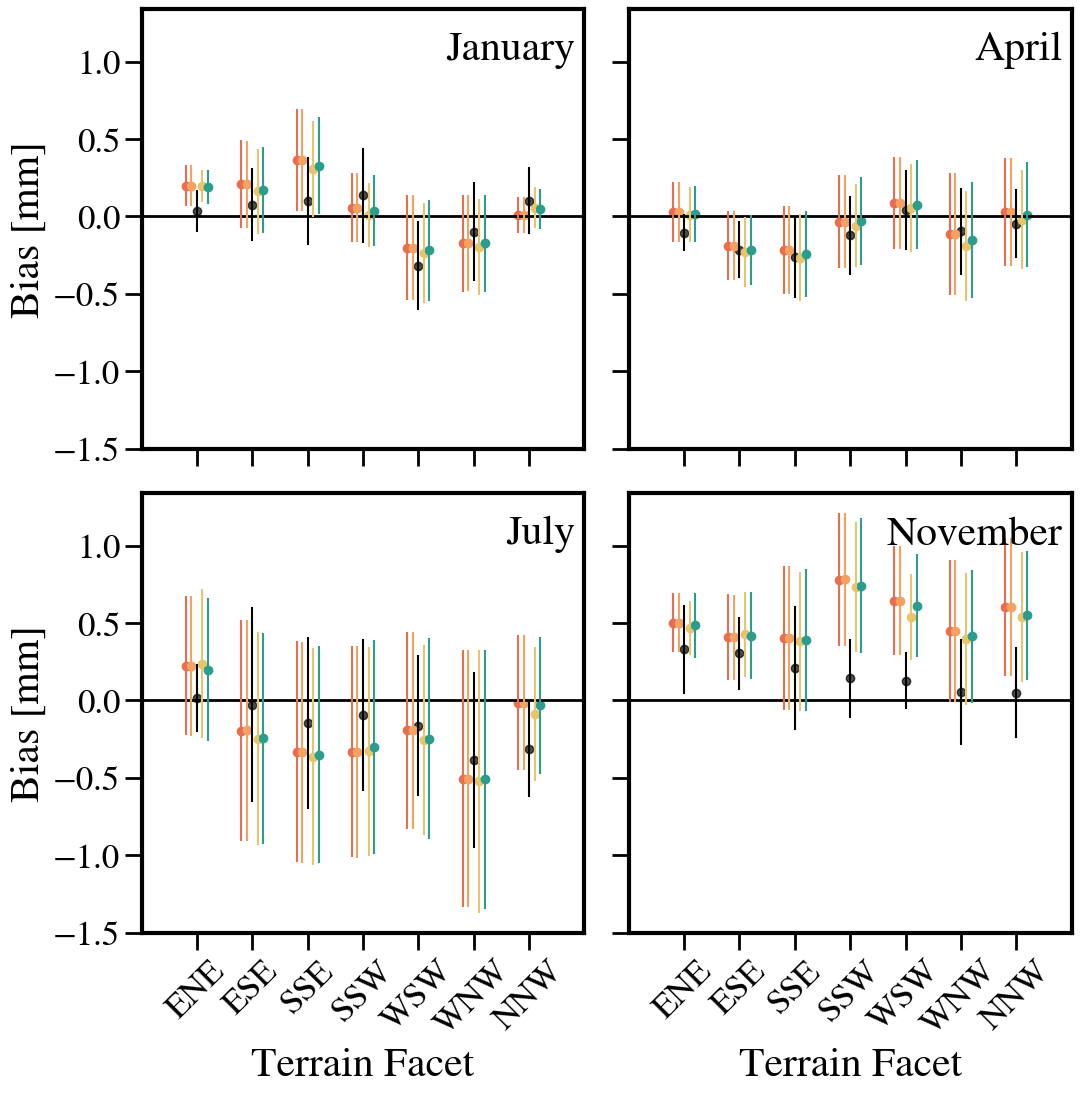

In [185]:
fig, axes = plt.subplot_mosaic('AB;CD', sharex=True, sharey=True,figsize=(12, 12))

plt.subplots_adjust(hspace=0.1, wspace=0.1)

scale_d = 10
scale_m = 2

axes['A'].set_xlim([0,8*scale_d])

for month, ax in enumerate(['A', 'B', 'C', 'D']):
    axes[ax].plot([0*scale_d,9*scale_d], [0,0], color='black',lw=2)
    for model in range(len(models)):
        dat = models[model].bias.mean(dim='day').mean(dim='locations').data
        if model == 0:
            for direction in np.arange(1,len(terrain_facet_directions)):
                this_dir = np.where(tf == direction)[0]
                this_bias = dat[month,this_dir]
                axes[ax].scatter(direction*scale_d, np.mean(this_bias), color='black',alpha=0.7,label=model_names[model])
                axes[ax].errorbar(direction*scale_d, np.mean(this_bias), yerr=np.std(this_bias)/2, color='black',ls='None')
                
        elif model == 1:
            for direction in np.arange(1,len(terrain_facet_directions)):
                this_dir = np.where(tf == direction)[0]
                this_bias = dat[month,this_dir]
                axes[ax].scatter(scale_d*(direction)+scale_m*(-1), np.mean(this_bias), color='#E76F51',label=model_names[model])
                axes[ax].errorbar(scale_d*(direction)+scale_m*(-1), np.mean(this_bias), yerr=np.std(this_bias)/2, color='#E76F51',ls='None')
                
        elif model == 2:
            for direction in np.arange(1,len(terrain_facet_directions)):
                this_dir = np.where(tf == direction)[0]
                this_bias = dat[month,this_dir]
                axes[ax].scatter(scale_d*(direction)+scale_m*(-0.5), np.mean(this_bias), color='#F4A261',label=model_names[model])
                axes[ax].errorbar(scale_d*(direction)+scale_m*(-0.5), np.mean(this_bias), yerr=np.std(this_bias)/2, color='#F4A261',ls='None')

        elif model == 3:
            for direction in np.arange(1,len(terrain_facet_directions)):
                this_dir = np.where(tf == direction)[0]
                this_bias = dat[month,this_dir]
                axes[ax].scatter(scale_d*(direction)+scale_m*(0.5), np.mean(this_bias), color='#E9C46A',label=model_names[model])
                axes[ax].errorbar(scale_d*(direction)+scale_m*(0.5), np.mean(this_bias), yerr=np.std(this_bias)/2, color='#E9C46A',ls='None')

        elif model == 4:
            for direction in np.arange(1,len(terrain_facet_directions)):
                this_dir = np.where(tf == direction)[0]
                this_bias = dat[month,this_dir]
                axes[ax].scatter(scale_d*(direction)+scale_m*(1), np.mean(this_bias), color='#2A9D8F',label=model_names[model])
                axes[ax].errorbar(scale_d*(direction)+scale_m*(1), np.mean(this_bias), yerr=np.std(this_bias)/2, color='#2A9D8F',ls='None')
    plt.text(.98, .95, f"{datetime.date(2023,months[month],1).strftime('%B')}", ha='right', va='top', transform=axes[ax].transAxes)


#axes['A'].legend(frameon=False, fontsize=18, loc='upper right')
axes['C'].set_xticks(np.arange(1,8)*scale_d, terrain_facet_directions[1:], rotation=45)
axes['D'].set_xticks(np.arange(1,8)*scale_d, terrain_facet_directions[1:], rotation=45)

axes['A'].set_ylabel('Bias [mm]')
axes['C'].set_ylabel('Bias [mm]')
axes['C'].set_xlabel('Terrain Facet')
axes['D'].set_xlabel('Terrain Facet')

#plt.xticks(np.arange(1,8), terrain_facet_directions[1:], rotation=45)

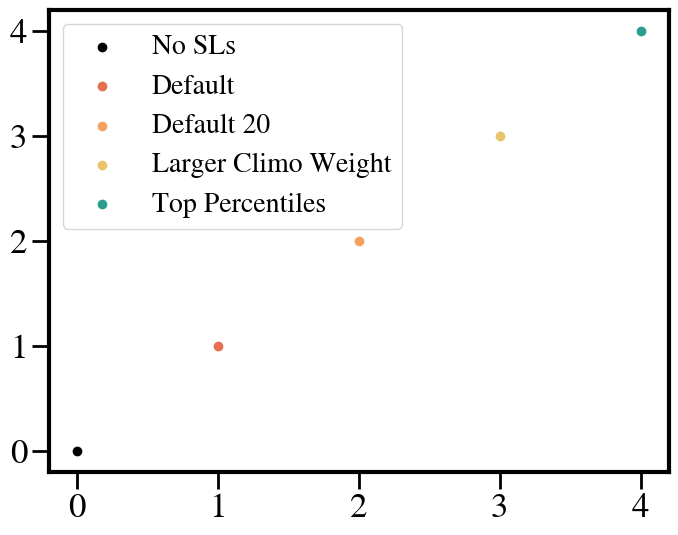

In [189]:
colors = ['black', '#E76F51', '#F4A261', '#E9C46A', '#2A9D8F']

for model in range(len(models)):
    dat = models[model].bias.mean(dim='day').mean(dim='locations').data
    plt.scatter(model,model, color=colors[model], label=model_names[model])

plt.legend()

# New Baselines

In [3]:
no_sl = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/month_bias_without_sl_CONUS_expanded.zarr')
default = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/month_bias_with_sl_CONUS_expanded.zarr')

climo = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/baselines/climo/month_bias_with_sl_CONUS_expanded.zarr')
terrain = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/baselines/terrain//month_bias_with_sl_CONUS_expanded.zarr')
facets = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/baselines/facets/month_bias_with_sl_CONUS_expanded.zarr')
#climo_terrain = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/baselines/climo_terrain/month_bias_with_sl_CONUS_expanded.zarr')
diurnal = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/diurnal_cycle/month_bias_with_sl_CONUS_expanded_v2.zarr')

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [4]:
models = [no_sl, default, climo, terrain, facets, diurnal]
model_names = ['No SLs', 'Default', 'Climo', 'Terrain', 'Facets', 'Diurnal']

#models = [no_sl, default, facets, climo_terrain]
#model_names = ['No SLs', 'Default', 'Facets', 'Climo & Terrain']

months = [1,4,7,11]

  0%|          | 0/6 [00:00<?, ?it/s]

Text(0, 0.5, 'Bias [mm]')

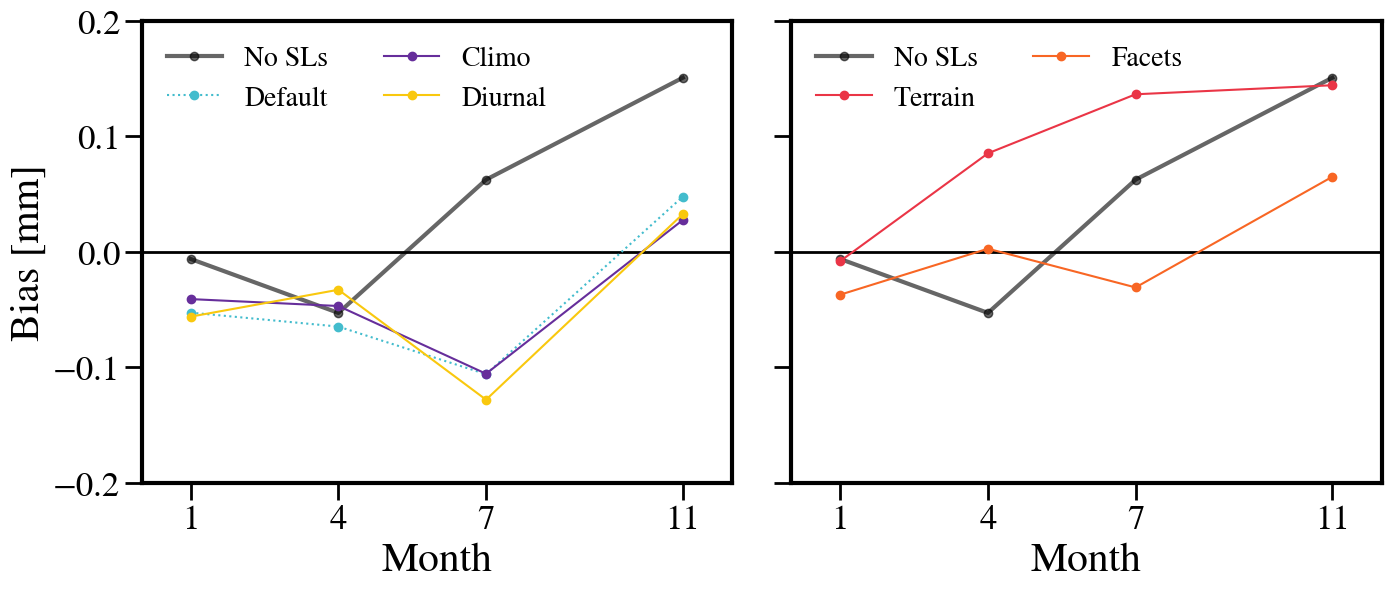

In [5]:
fig, axes = plt.subplots(1,2, sharex=True,sharey=True, figsize=(16, 6))
plt.subplots_adjust(wspace=0.1)
axes[0].set_ylim([-0.2, 0.2])
axes[0].set_xlim([0,12])

for model in tqdm(range(len(models))):
    dat = models[model].bias.mean(dim='day').mean(dim='grid_point').data[:,::50]
    #err = models[model].bias.std(dim='day').std(dim='grid_point').std(dim='locations').data
    if model == 0: #no SLs
        dat = models[model].bias.mean(dim='day').mean(dim='grid_point').data
        axes[0].plot(months, np.mean(dat,axis=1), lw=3, marker='o', color='black',alpha=0.6,label=model_names[model])
        #axes[0].errorbar(months, dat, yerr=err, color='black',alpha=0.6, ls='None')
        axes[1].plot(months, np.mean(dat,axis=1), lw=3, marker='o', color='black',alpha=0.6,label=model_names[model])
        #axes[1].errorbar(months, dat, yerr=err, color='black',alpha=0.6, ls='None')
    elif model == 1:
        axes[0].plot(months, np.mean(dat,axis=1), color='#43BCCD', lw=1.5,ls=':', marker='o',label=model_names[model])
        #axes[0].errorbar(months, dat, yerr=err, color='#43BCCD', ls='None')
    elif model == 2:
        axes[0].plot(months, np.mean(dat,axis=1), color='#662E9B', lw=1.5,marker='o',label=model_names[model])
        #axes[0].errorbar(months, dat, yerr=err, color='#662E9B', ls='None')
    elif model == 3:
        axes[1].plot(months, np.mean(dat,axis=1), color='#EA3546', lw=1.5,marker='o',label=model_names[model])
        #axes[1].errorbar(months, dat, yerr=err, color='#EA3546', ls='None')
    elif model == 4:
        axes[1].plot(months, np.mean(dat,axis=1), color='#F86624', lw=1.5, marker='o',label=model_names[model])
        #axes[1].errorbar(months, dat, yerr=err, color='#F86624', ls='None')
    elif model == 5:
        axes[0].plot(months, np.mean(dat,axis=1), color='#F9C80E', lw=1.5, marker='o',label=model_names[model])
        #axes.errorbar(months, dat, yerr=err, color='#F9C80E', ls='None')

for a in range(2):
    axes[a].plot([0,12], [0,0], color='black', zorder=0, lw=2)
    axes[a].legend(frameon=False, loc='upper left', ncol=2)
    axes[a].set_xticks(months)
    axes[a].set_xlabel('Month')

axes[0].set_ylabel('Bias [mm]')

In [5]:
consts = xr.open_dataset('/scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/precip/blend.precip_const.co.2p5.nc')
locations = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/expanded_conus_grid_sample_points.zarr')

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [6]:
consts

<xarray.Dataset> Size: 322MB
Dimensions:               (ya: 1597, xa: 2345, ngds_grib2: 200,
                           smooth_radius: 5, ngds_tdlpack: 12)
Coordinates:
    latitude              (ya, xa) float32 15MB ...
    longitude             (ya, xa) float32 15MB ...
  * smooth_radius         (smooth_radius) int32 20B 1 5 10 20 40
  * xa                    (xa) float32 9kB 0.0 2.54e+03 ... 5.951e+06 5.953e+06
  * ya                    (ya) float32 6kB 0.0 2.54e+03 ... 4.051e+06 4.053e+06
Dimensions without coordinates: ngds_grib2, ngds_tdlpack
Data variables: (12/15)
    analysis_source_mask  (ya, xa) float32 15MB ...
    conuslandmask         (ya, xa) float32 15MB ...
    greatlakes_mask       (ya, xa) float32 15MB ...
    grib2_gds             (ngds_grib2) int32 800B ...
    land_proximity        (ya, xa) float32 15MB ...
    landmask              (ya, xa) float32 15MB ...
    ...                    ...
    terrain_facets        (smooth_radius, ya, xa) float32 75MB ...
    terrain_smoothed      (smooth_radius, ya, xa) float32 75MB ...
    validmask             (ya, xa) float32 15MB ...
    validmask_capa        (ya, xa) int16 7MB ...
    validmask_ccpa        (ya, xa) int16 7MB ...
    validmask_cmorph      (ya, xa) int16 7MB ...
Attributes:
    title:        Masks and Terrain for Blend Precip Quantile Mapping
    Conventions:  CF-1.6
    institution:  ESRL/PSD NWS/MDL
    domain:       co

In [24]:
locations

<xarray.Dataset> Size: 12kB
Dimensions:        (location: 500)
Coordinates:
  * location       (location) int64 4kB 0 1 2 3 4 5 ... 494 495 496 497 498 499
Data variables:
    latitude_idx   (location) int64 4kB ...
    longitude_idx  (location) int64 4kB ...
Attributes:
    description:  CONUS lat/lon grid indices for points chosen to sample CONU...

In [25]:
terrain_heights = consts.terrain.data
lat_idx = locations.latitude_idx.data
lon_idx = locations.longitude_idx.data

In [40]:
np.shape(dat)

(4, 500, 30)

In [42]:
np.shape(np.mean(dat[0], axis=1))

(500,)

Text(0, 0.5, 'Bias [mm]')

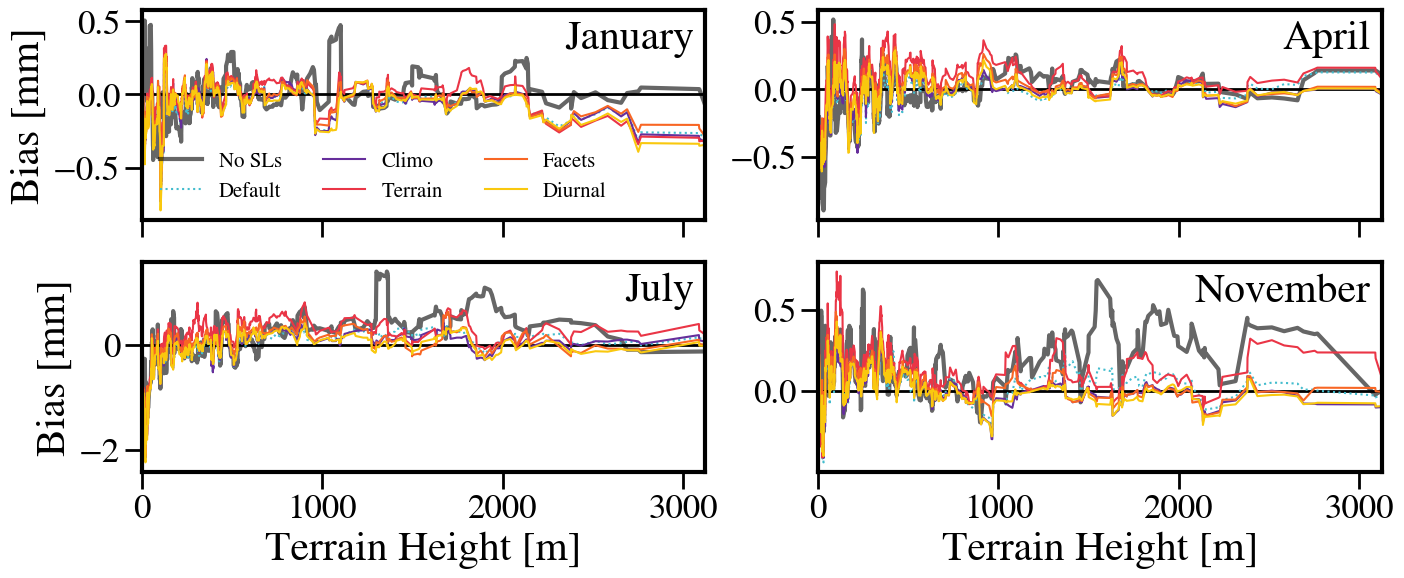

In [43]:
fig, axes = plt.subplots(2,2, sharex=True, figsize=(16, 6))
#plt.subplots_adjust(hspace=0.3, wspace=0.3)
#axes[0,0].set_ylim([-.05, 0.1])

th = terrain_heights[lat_idx, lon_idx]
N = 10 #convolution window

in_order = np.argsort(th)
axes[0,0].set_xlim([0,np.max(th)])

for i in range(2):
    for j in range(2):
        month = 2*i + j
        axes[i,j].plot([0,np.max(th)], [0,0], color='black', zorder=0, lw=2)
        for model in range(len(models)):
            dat = models[model].bias.mean(dim='day').data[:,:,::50]
            if model == 0:
                axes[i,j].plot(th[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), lw=3, color='black',alpha=0.6,label=model_names[model])
            elif model == 1:
                axes[i,j].plot(th[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), color='#43BCCD', lw=1.5,ls=':', label=model_names[model])
            elif model == 2:
                axes[i,j].plot(th[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), color='#662E9B', lw=1.5,label=model_names[model])
            elif model == 3:
                axes[i,j].plot(th[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), color='#EA3546', lw=1.5,label=model_names[model])
            elif model == 4:
                axes[i,j].plot(th[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), color='#F86624', lw=1.5,label=model_names[model])
            elif model == 5:
                axes[i,j].plot(th[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), color='#F9C80E', lw=1.5,label=model_names[model])
        
        ymin, ymax = axes[i,j].get_ylim()
        xmin, xmax = axes[i,j].get_xlim()
        #axes[month].annotate(f"{datetime.date(2023,months[month],1).strftime('%B')}", xy=(2500,ymax-0.4*ymax))
        plt.text(.98, .95, f"{datetime.date(2023,months[month],1).strftime('%B')}", ha='right', va='top', transform=axes[i,j].transAxes)

        

axes[0,0].legend(frameon=False, loc='lower left', ncol=3, fontsize=15)
axes[1,0].set_xlabel('Terrain Height [m]')
axes[1,1].set_xlabel('Terrain Height [m]')
axes[0,0].set_ylabel('Bias [mm]')
axes[1,0].set_ylabel('Bias [mm]')
#axes.set_xticks(months)
#fig.text(x=0.45, y=-0.05, s='Month', fontdict={'fontsize': 40})
#fig.text(x=0.045, y=0.07, s=f'Bias (Forecast - Analysis)', rotation='vertical',fontdict={'fontsize': 35})
#axes.set_title("CONUS Sample")

I want to do this plot as a function of complex terrain: localized terrain height standard deviation

No -- too slow

Savitzky Golay filter for 2D gradient

In [45]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

{230.0: ([<matplotlib.lines.Line2D at 0x14a5be162320>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x14a5be162590>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x14a5be162830>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x14a5be162ad0>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x14a5be162d70>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x14a5be163010>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x14a5be1632b0>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x14a5be163550>], [])}

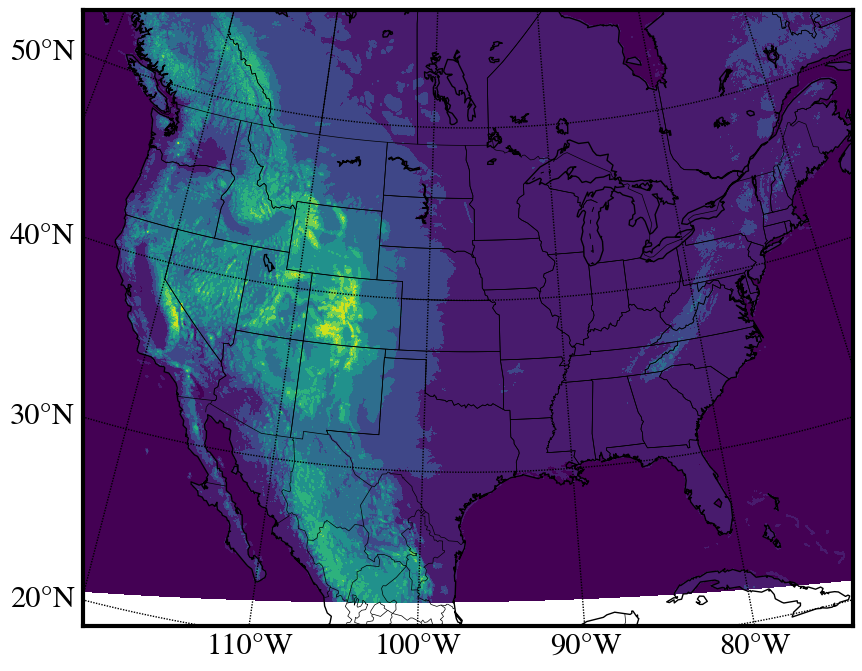

In [37]:
fig, axes = plt.subplots(1,1, figsize=(16,8))

#GEFS
lats, lons = consts.latitude.data, consts.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,terrain_heights,extend='both',ax=axes,cmap='viridis')


m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

In [46]:
test_sg_x, test_sg_y = sgolay2d(terrain_heights, 51, 20, derivative='both')

In [47]:
grad = np.sqrt(test_sg_x**2 + test_sg_y**2)

{230.0: ([<matplotlib.lines.Line2D at 0x14a5b8012fe0>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x14a5b8013250>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x14a5b80134f0>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x14a5b8013790>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x14a5b8013a30>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x14a5b8013cd0>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x14a5b8013fd0>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x14a5b804c250>], [])}

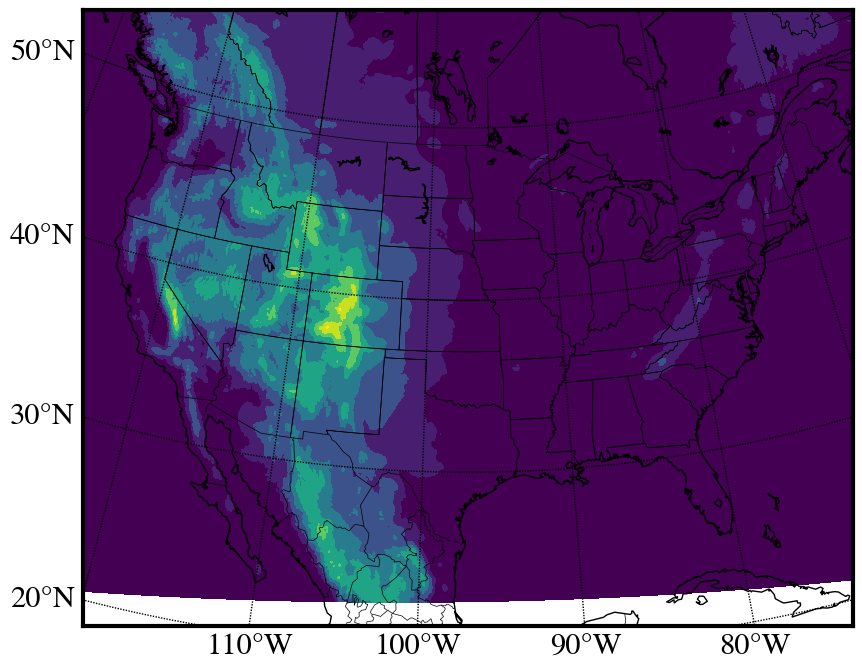

In [100]:
fig, axes = plt.subplots(1,1, figsize=(16,8))

#GEFS
lats, lons = consts.latitude.data, consts.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,grad,extend='both',ax=axes,cmap='viridis',)


m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

In [59]:
no_sl

<xarray.Dataset> Size: 14MB
Dimensions:     (month: 4, day: 30, grid_point: 500, locations: 30)
Coordinates:
  * day         (day) int64 240B 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29
  * grid_point  (grid_point) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * locations   (locations) int64 240B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29
  * month       (month) int64 32B 1 4 7 11
Data variables:
    bias        (month, day, grid_point, locations) float64 14MB 0.5478 ... 0.0

In [49]:
selected_grad = grad[lat_idx, lon_idx]/np.max(grad[lat_idx, lon_idx])

Text(0.45, 0.9, 'November')

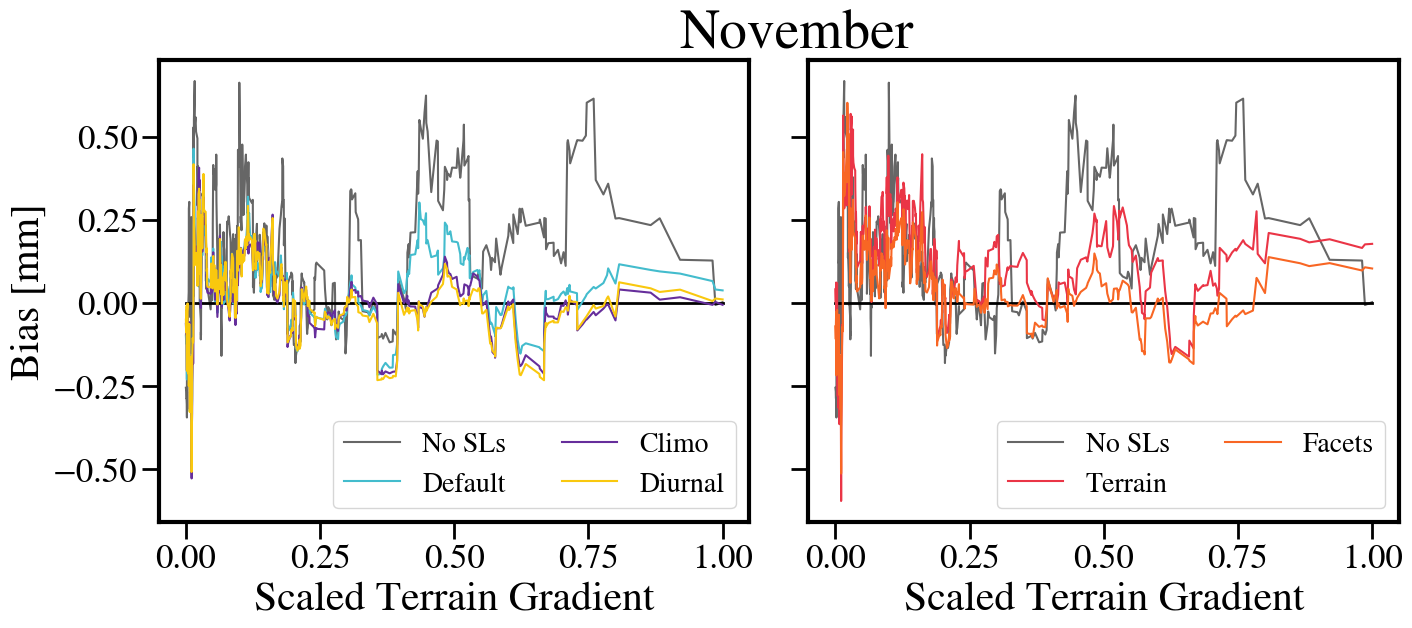

In [53]:
fig, axes = plt.subplots(1,2, sharex=True,sharey=True, figsize=(16, 6))
plt.subplots_adjust(wspace=0.1)

month=-1
N=10

in_order = np.argsort(selected_grad)

for model in range(len(models)):
    dat = models[model].bias.mean(dim='day').data[:,:,::50]
    #err = models[model].bias.std(dim='day').std(dim='grid_point').std(dim='locations').data
    if model == 0: #no SLs
        axes[0].plot(selected_grad[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), color='black',alpha=0.6,label=model_names[model])
        #axes[0].errorbar(months, dat, yerr=err, color='black',alpha=0.6, ls='None')
        axes[1].plot(selected_grad[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'),  color='black',alpha=0.6,label=model_names[model])
        #axes[1].errorbar(months, dat, yerr=err, color='black',alpha=0.6, ls='None')
    elif model == 1:
        axes[0].plot(selected_grad[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), color='#43BCCD', label=model_names[model])
        #axes[0].errorbar(months, dat, yerr=err, color='#43BCCD', ls='None')
    elif model == 2:
        axes[0].plot(selected_grad[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), color='#662E9B',label=model_names[model])
        #axes[0].errorbar(months, dat, yerr=err, color='#662E9B', ls='None')
    elif model == 3:
        axes[1].plot(selected_grad[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), color='#EA3546', label=model_names[model])
        #axes[1].errorbar(months, dat, yerr=err, color='#EA3546', ls='None')
    elif model == 4:
        axes[1].plot(selected_grad[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), color='#F86624',  label=model_names[model])
        #axes[1].errorbar(months, dat, yerr=err, color='#F86624', ls='None')
    elif model == 5:
        axes[0].plot(selected_grad[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), color='#F9C80E', label=model_names[model])
        #axes.errorbar(months, dat, yerr=err, color='#F9C80E', ls='None')

for a in range(2):
    axes[a].plot([0,1], [0,0], color='black', zorder=0, lw=2)
    axes[a].legend(loc='lower right', ncol=2)
    axes[a].set_xlabel('Scaled Terrain Gradient')

axes[0].set_ylabel('Bias [mm]')
fig.text(x=0.45, y=0.9, s='November', fontdict={'fontsize': 40})

{230.0: ([<matplotlib.lines.Line2D at 0x14a5b772a5c0>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x14a5b772a830>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x14a5b772aad0>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x14a5b772ad70>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x14a5b772b010>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x14a5b772b2b0>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x14a5b772b550>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x14a5b772b7f0>], [])}

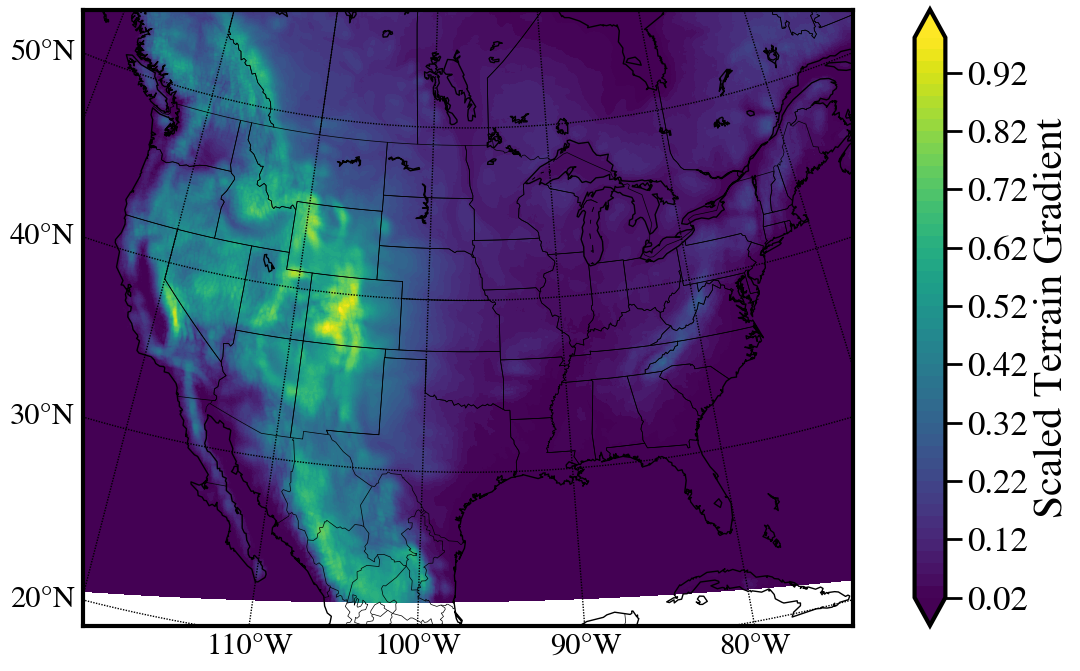

In [106]:
fig, axes = plt.subplots(1,1, figsize=(16,8))

#GEFS
lats, lons = consts.latitude.data, consts.longitude.data
m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')
xx, yy = m(lons,lats) #note to self, x=lons y=lats

cs = m.contourf(xx,yy,grad/np.max(grad),extend='both',levels=50,ax=axes,cmap='viridis',)
plt.colorbar(cs, label="Scaled Terrain Gradient")


m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

# Full CONUS 2.0

In [285]:
consts = xr.open_dataset('/scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/precip/blend.precip_const.co.2p5.nc')

In [286]:
landmask = consts.landmask.data.astype(np.int32)

In [296]:
landmask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int32)

In [287]:
lat = consts.latitude.data
lon = consts.longitude.data

In [288]:
thin = 32
thinned_mask = landmask[::thin,::thin]
lat_thinned = lat[::thin, ::thin]
lon_thinned = lon[::thin, ::thin]

In [314]:
lat_idx = np.arange(0,np.shape(lat)[0], 32)
lon_idx = np.arange(0, np.shape(lat)[1],32)

In [ ]:
landmask[la]

In [315]:
gy, gx=np.meshgrid(lat_idx, lon_idx, indexing='ij')

In [316]:
grid_points =  np.reshape((gx, gy), (2, -1), order='C').T

In [317]:
lat_idx = grid_points[:,1]
lon_idx = grid_points[:,0]

In [319]:
np.where(landmask[lat_idx, lon_idx] == 1)

(array([  27,   28,   29, ..., 3697, 3698, 3699]),)

In [320]:
valid_gps = grid_points[np.where(landmask[lat_idx, lon_idx] == 1)[0]]

In [321]:
valid_gps

array([[ 864,    0],
       [ 896,    0],
       [ 928,    0],
       ...,
       [2272, 1568],
       [2304, 1568],
       [2336, 1568]])

In [327]:
lat[1568,2336]

53.882175

In [328]:
lon[1568,2336]

300.4537

In [330]:
np.shape(lon)

(1597, 2345)

In [331]:
np.max(valid_gps[:,0])

2336

{200.0: ([<matplotlib.lines.Line2D at 0x1512eaaee5f0>], []),
 210.0: ([<matplotlib.lines.Line2D at 0x1512eaaeeaa0>], []),
 220.0: ([<matplotlib.lines.Line2D at 0x1512eaaec280>], []),
 230.0: ([<matplotlib.lines.Line2D at 0x1512eaaed300>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x1512eaaee350>],
  [Text(1072000.0, -80000.0, '120°W')]),
 250.0: ([<matplotlib.lines.Line2D at 0x1512eaaec9a0>],
  [Text(2368000.0, -80000.0, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x1512eaaecbb0>],
  [Text(3632000.0, -80000.0, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x1512eaaeffa0>],
  [Text(4880000.0, -80000.0, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x1512eaaee080>],
  [Text(6152000.0, -80000.0, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x1512eaaedde0>],
  [Text(7480000.0, -80000.0, '70°W')]),
 300.0: ([<matplotlib.lines.Line2D at 0x1512e5899cc0>], []),
 310.0: ([<matplotlib.lines.Line2D at 0x1512eabe7550>], []),
 320.0: ([<matplotlib.lines.Line2D at 0x1512eabe7610>],

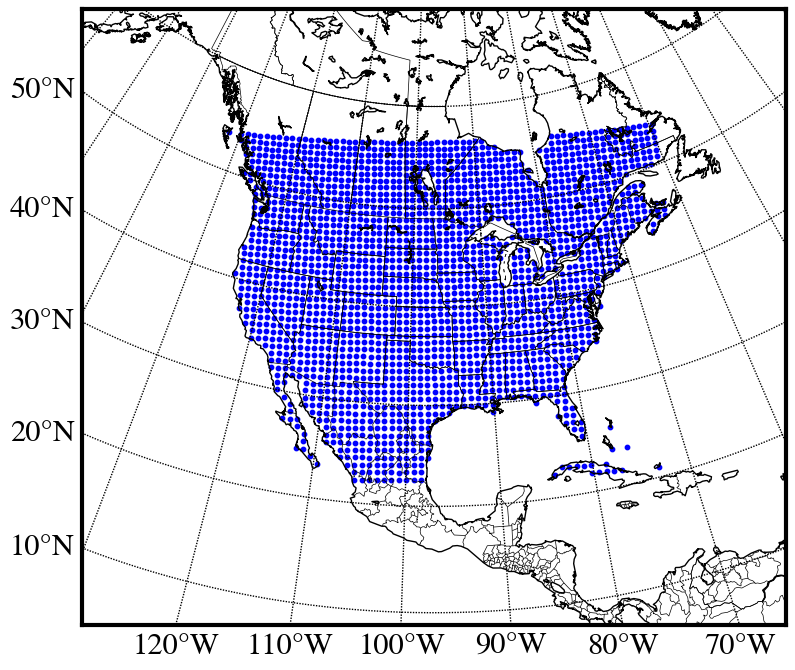

In [332]:
fig, axes = plt.subplots(1,1, figsize=(16,8))

#GEFS
m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=8e6,height=7e6, resolution='l')

x, y = m(lon[valid_gps[:,1], valid_gps[:,0]], lat[valid_gps[:,1], valid_gps[:,0]])  # transform coordinates
sc = plt.scatter(x, y, s=10, c='blue')



m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

In [333]:
valid_x = valid_gps[:,0]
valid_y = valid_gps[:,1]

In [335]:
ds = xr.Dataset(
    data_vars=dict(
        latitude_idx=(["grid_point"], valid_y),
        longitude_idx=(["grid_point"], valid_x),
    ),
    coords=dict(
        grid_point=np.arange(len(valid_y)),
    ),
    attrs=dict(description="32x thinned CONUS land points"),
)

In [ ]:
len()

In [338]:
ds.to_netcdf('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/thinned_conus_grid.nc', mode='w')

In [8]:
import re
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split('(\d+)', s)]


files=sorted(glob("/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/thinned_conus_baselines/*/bias*_with_sl_CONUS_24h.zarr"), key=natsort)

In [30]:
no_sl = xr.open_mfdataset(sorted(glob("/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/thinned_conus_baselines/climo/bias*_without_sl_CONUS_24h.zarr"), key=natsort),
                         combine='nested', concat_dim=[pd.Index([1,4,7,11], name="month")], engine='zarr')

climo = xr.open_mfdataset(files[:4], combine='nested', concat_dim=[pd.Index([1,4,7,11], name="month")], engine='zarr')
facets = xr.open_mfdataset(files[4:8], combine='nested', concat_dim=[pd.Index([1,4,7,11], name="month")], engine='zarr')
terrain = xr.open_mfdataset(files[8:], combine='nested', concat_dim=[pd.Index([1,4,7,11], name="month")], engine='zarr')

f = files=sorted(glob("/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/coeffs_from_bias/bias*_with_sl_CONUS_24h.zarr"), key=natsort)

optimized = xr.open_mfdataset(f, combine='nested', concat_dim=[pd.Index([1,4,7,11], name="month")], engine='zarr')

In [31]:
models = [no_sl, climo, terrain, facets, optimized]
months = [1,4,7,11]
model_names = ['No SL', 'Climo', 'Terrain', 'Facets', 'Optimized']

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0, 0.5, 'Square Bias [mm$^2$]')

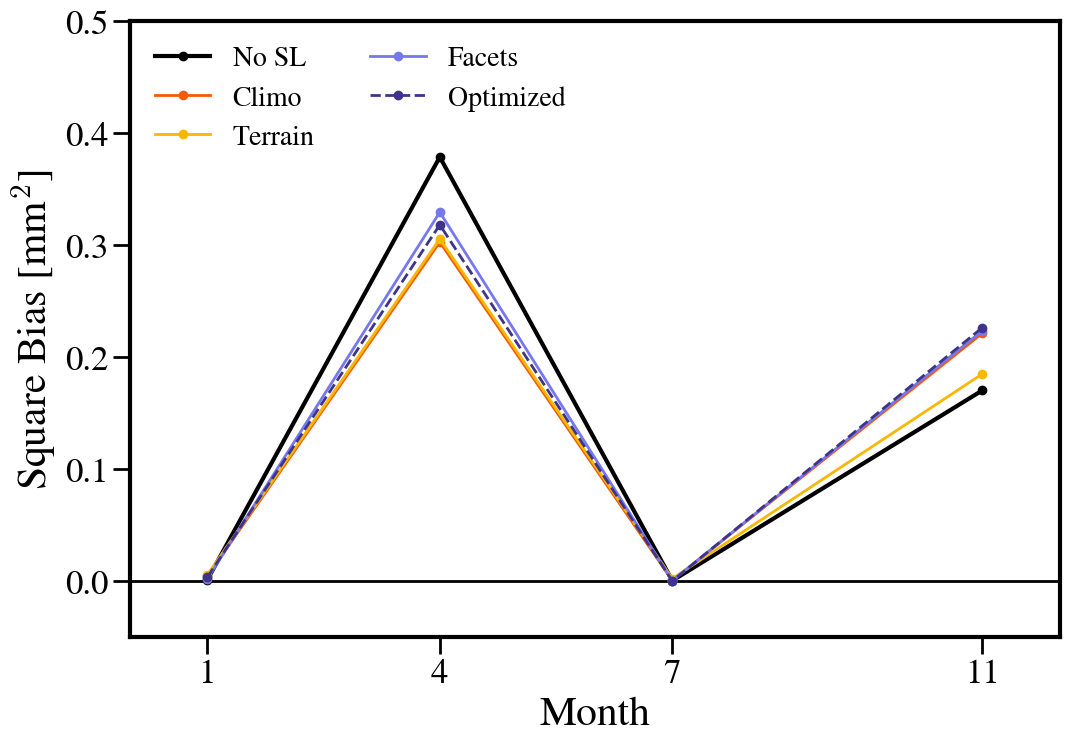

In [34]:
fig, axes = plt.subplots(1,1, sharex=True,sharey=True, figsize=(12, 8))
plt.subplots_adjust(wspace=0.1)
axes.set_ylim([-0.05, 0.5])
axes.set_xlim([0,12])

coolors = ['black', '#f35b04', '#f7b801', '#7678ed', '#3d348b']

for model in tqdm(range(len(models))):
    dat = models[model].bias.mean(dim='day').mean(dim='member').data.compute()
    mn , gp = np.where(np.isfinite(dat) == False)
    dat[mn,gp] = np.nan
    dat = np.nanmean(dat, axis=1)**2
    #err = models[model].bias.std(dim='day').std(dim='grid_point').std(dim='locations').data
    if model == 0: #no SLs
        #dat = models[model].bias.mean(dim='day').mean(dim='grid_point').data
        axes.plot(months, dat, lw=3, marker='o', color=coolors[model],label=model_names[model])
        #axes[0].errorbar(months, dat, yerr=err, color='black',alpha=0.6, ls='None')
        #axes[1].plot(months, dat, lw=3, marker='o', color='black',alpha=0.6,label=model_names[model])
        #axes[1].errorbar(months, dat, yerr=err, color='black',alpha=0.6, ls='None')
    elif model == 1:
        axes.plot(months, dat, color=coolors[model], lw=2,marker='o',label=model_names[model])
        #axes[0].errorbar(months, dat, yerr=err, color='#43BCCD', ls='None')
    elif model == 2:
        axes.plot(months, dat, color=coolors[model], lw=2,marker='o',label=model_names[model])
        #axes[0].errorbar(months, dat, yerr=err, color='#662E9B', ls='None')
    elif model == 3:
        axes.plot(months, dat, color=coolors[model], lw=2,marker='o',label=model_names[model])
        #axes[1].errorbar(months, dat, yerr=err, color='#EA3546', ls='None')
    elif model == 4:
        axes.plot(months, dat, color=coolors[model], lw=2,marker='o',ls='--',label=model_names[model])
        #axes[1].plot(months, dat, color='#F86624', lw=1.5, marker='o',label=model_names[model])
        #axes[1].errorbar(months, dat, yerr=err, color='#F86624', ls='None')
    #elif model == 5:
        #axes[0].plot(months, dat, color='#F9C80E', lw=1.5, marker='o',label=model_names[model])
        #axes.errorbar(months, dat, yerr=err, color='#F9C80E', ls='None')

#for a in range(2):
axes.plot([0,12], [0,0], color='black', zorder=0, lw=2)
axes.legend(frameon=False, loc='upper left', ncol=2)
axes.set_xticks(months)
axes.set_xlabel('Month')

axes.set_ylabel('Square Bias [mm$^2$]')

In [66]:
consts = xr.open_dataset('/scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/precip/blend.precip_const.co.2p5.nc')

In [67]:
terrain_height = consts.terrain.data
lats = consts.latitude.data
lons = consts.longitude.data

In [3]:
conus_gp = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/thinned_conus_grid.nc')

In [4]:
lat_idx = conus_gp.latitude_idx.data
lon_idx = conus_gp.longitude_idx.data

In [5]:
len(lat_idx)

2260

Text(0, 0.5, 'Bias [mm]')

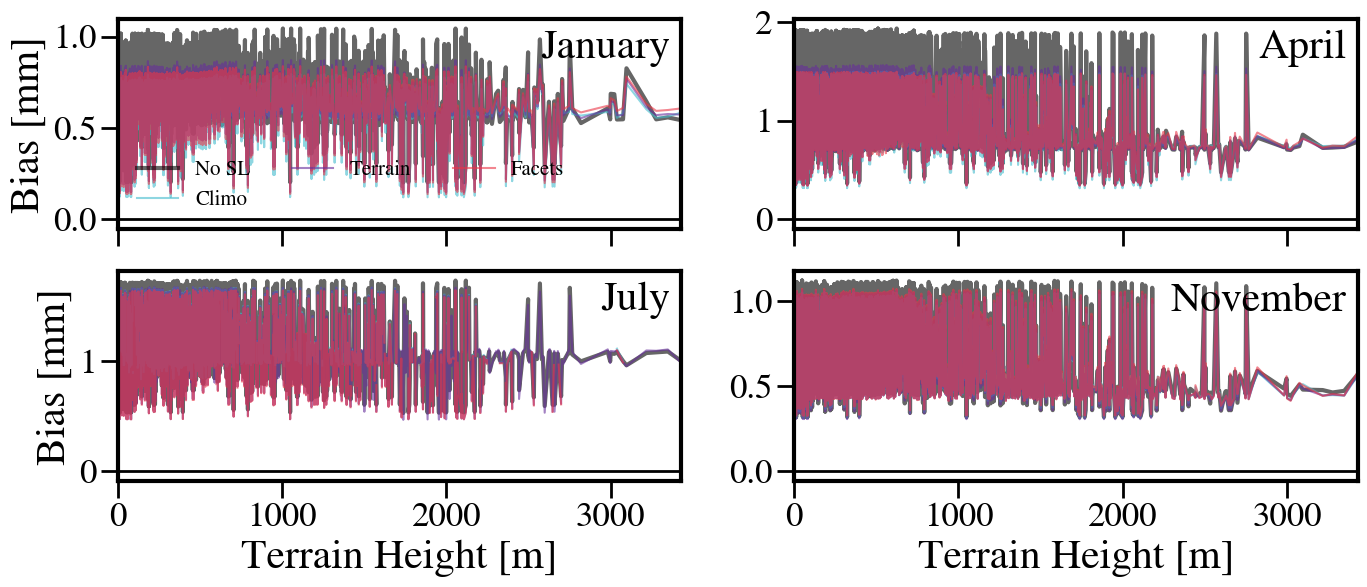

In [78]:
fig, axes = plt.subplots(2,2, sharex=True, figsize=(16, 6))
#plt.subplots_adjust(hspace=0.3, wspace=0.3)
#axes[0,0].set_ylim([-.05, 0.1])

th = terrain_height[lat_idx, lon_idx]
N = 500 #convolution window

in_order = np.argsort(th)
axes[0,0].set_xlim([0,np.max(th)])

for i in range(2):
    for j in range(2):
        month = 2*i + j
        axes[i,j].plot([0,np.max(th)], [0,0], color='black', zorder=0, lw=2)
        for model in range(len(models)):
            dat = models[model].bias.mean(dim='day').mean(dim='member').data.compute()
            if model == 0:
                axes[i,j].plot(th[in_order], np.convolve(dat[month], np.ones(N)/N, mode='same')[in_order], lw=3, color='black',alpha=0.6,label=model_names[model])
            elif model == 1:
                axes[i,j].plot(th[in_order], np.convolve(dat[month], np.ones(N)/N, mode='same')[in_order], color='#43BCCD', alpha=0.6,lw=1.5,label=model_names[model])
            elif model == 2:
                axes[i,j].plot(th[in_order], np.convolve(dat[month], np.ones(N)/N, mode='same')[in_order], color='#662E9B', alpha=0.6,lw=1.5,label=model_names[model])
            elif model == 3:
                axes[i,j].plot(th[in_order], np.convolve(dat[month], np.ones(N)/N, mode='same')[in_order], color='#EA3546', alpha=0.6,lw=1.5,label=model_names[model])
            #elif model == 4:
            #    axes[i,j].plot(th[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), color='#F86624', lw=1.5,label=model_names[model])
            #elif model == 5:
            #    axes[i,j].plot(th[in_order], np.convolve(np.mean(dat[month], axis=1)[in_order], np.ones(N)/N, mode='same'), color='#F9C80E', lw=1.5,label=model_names[model])
        
        ymin, ymax = axes[i,j].get_ylim()
        xmin, xmax = axes[i,j].get_xlim()
        #axes[month].annotate(f"{datetime.date(2023,months[month],1).strftime('%B')}", xy=(2500,ymax-0.4*ymax))
        plt.text(.98, .95, f"{datetime.date(2023,months[month],1).strftime('%B')}", ha='right', va='top', transform=axes[i,j].transAxes)

        

axes[0,0].legend(frameon=False, loc='lower left', ncol=3, fontsize=15)
axes[1,0].set_xlabel('Terrain Height [m]')
axes[1,1].set_xlabel('Terrain Height [m]')
axes[0,0].set_ylabel('Bias [mm]')
axes[1,0].set_ylabel('Bias [mm]')
#axes.set_xticks(months)
#fig.text(x=0.45, y=-0.05, s='Month', fontdict={'fontsize': 40})
#fig.text(x=0.045, y=0.07, s=f'Bias (Forecast - Analysis)', rotation='vertical',fontdict={'fontsize': 35})
#axes.set_title("CONUS Sample")

In [41]:
model_names

['No SL', 'Climo', 'Terrain', 'Facets', 'Optimized']

In [55]:
monthly_biases = np.zeros((4,len(models)-2))

for model in tqdm(range(1,len(model_names)-1)):
    dat = models[model].bias.mean(dim='day').mean(dim='member').data.compute()
    mn , gp = np.where(np.isfinite(dat) == False)
    dat[mn,gp] = np.nan
    dat = np.nanmean(dat, axis=1)
    print(dat)
    monthly_biases[:,model-1] = np.abs(dat)

  0%|          | 0/3 [00:00<?, ?it/s]

[-0.06530155  0.55008084 -0.02221368  0.47029598]
[-0.07403552  0.55261633 -0.04703332  0.4299849 ]
[-0.0416268   0.57382599 -0.01661717  0.47270984]


In [39]:
dat = models[0].bias.mean(dim='day').mean(dim='member').data.compute()

In [54]:
monthly_biases[3]

array([0.22117831, 0.18488702, 0.2234546 ])

In [56]:
for month in range(len(months)):
    this_month = 1.0 - (monthly_biases[month]/np.sum(monthly_biases[month]))
    #print(this_month)
    normed_coeffs = this_month / np.max(this_month)
    
    print(f"Weights for {datetime.datetime(2023, months[month], 1).strftime('%B')}: ")
    print(f"    gamma = {normed_coeffs[0]:.3f} ({monthly_biases[month,0]:.6f})")
    print(f"    terrain = {normed_coeffs[1]:.3f} ({monthly_biases[month,1]:.6f})")
    print(f"    facets = {normed_coeffs[2]:.3f} ({monthly_biases[month,2]:.6f})\n")
    

Weights for January: 
    gamma = 0.830 (0.065302)
    terrain = 0.767 (0.074036)
    facets = 1.000 (0.041627)

Weights for April: 
    gamma = 1.000 (0.550081)
    terrain = 0.998 (0.552616)
    facets = 0.979 (0.573826)

Weights for July: 
    gamma = 0.919 (0.022214)
    terrain = 0.561 (0.047033)
    facets = 1.000 (0.016617)

Weights for November: 
    gamma = 0.957 (0.470296)
    terrain = 1.000 (0.429985)
    facets = 0.955 (0.472710)



In [111]:
this_month

array([0.69291375, 0.69267614, 0.71015151])

In [112]:
1.0 - (this_month / np.sum(this_month))

array([0.33062941, 0.33051603, 0.33885455])

In [12]:
dat = climo.bias.mean(dim='member').data.compute()

In [14]:
np.where(np.isfinite(dat) == False)

(array([2, 2]), array([ 5, 21]), array([210, 628]))

In [15]:
mn, day,gp = np.where(np.isfinite(dat) == False)
dat[mn,day,gp] = np.nan
dat = np.nanmean(dat, axis=2)

In [59]:
std_co

array([3.17042562, 5.11182504, 5.48676282, 4.142532  , 2.49739057,
       1.74104136, 2.11194086, 2.76639722, 2.26740246, 1.85290026,
       1.61976471, 2.57373379, 3.6740436 , 3.86180946, 4.10186241,
       3.76614759, 4.21931372, 4.31242818, 4.93780132, 5.67852248,
       5.15903364, 4.77223303, 4.48487322, 4.6051031 , 4.30193682,
       3.2422195 , 3.09560521, 2.97234541, 3.2914475 , 2.14153175])

Text(0, 0.5, 'Bias [mm]')

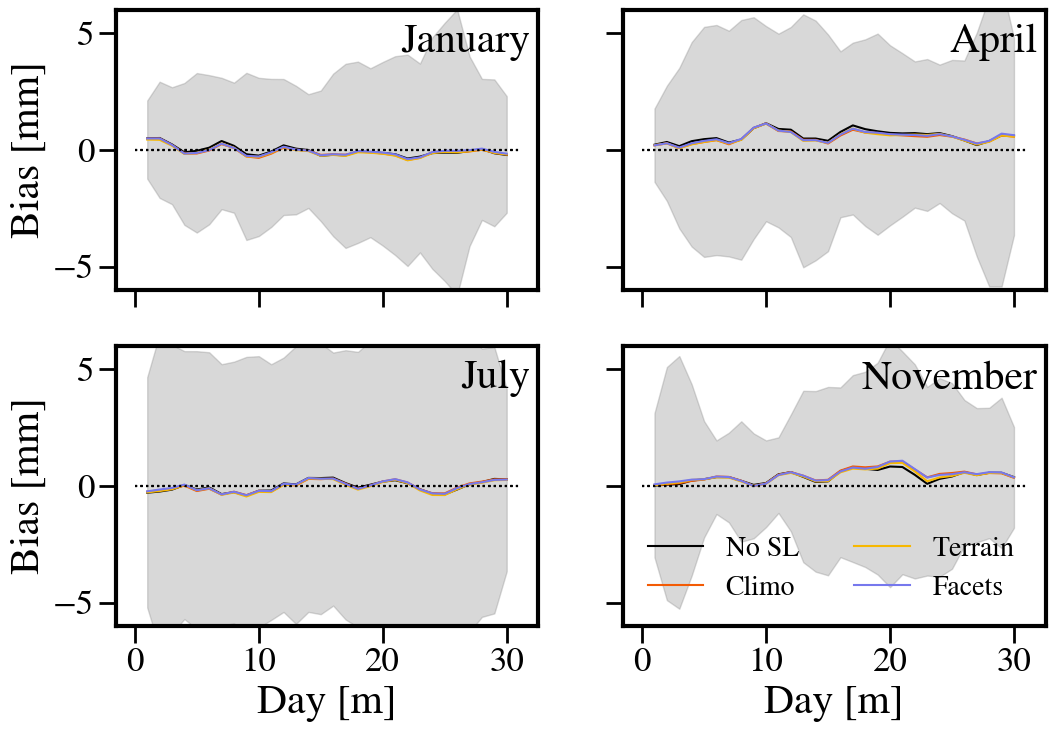

In [60]:
coolors = ['black', '#f35b04', '#f7b801', '#7678ed', '#3d348b']

fig, axes = plt.subplots(2,2, sharey=True, sharex=True, figsize=(12,8))
axes[0,0].set_ylim([-6, 6])

N = 3
month=0
for i in range(2):
    for j in range(2):
        month = 2*i + j
        for model in range(4):
            dat = models[model].bias.mean(dim='member').data.compute()
            mn, day,gp = np.where(np.isfinite(dat) == False)
            dat[mn,day,gp] = np.nan
            datmean = np.nanmean(dat, axis=2)
            co = np.convolve(datmean[month], np.ones(N)/N, mode='same')
            axes[i,j].plot(np.arange(1,31), co, color=coolors[model],label=f"{model_names[model]}")
            std = np.nanstd(dat, axis=2)
            std_co = np.convolve(std[month], np.ones(N)/N, mode='same')
            if model==2:
                axes[i,j].fill_between(np.arange(1,31), co-std_co, co+std_co,color='gray', alpha=0.3)
            axes[i,j].plot([0,31], [0,0], color='black', ls=':')
        plt.text(.98, .95, f"{datetime.date(2023,months[month],1).strftime('%B')}", ha='right', va='top', transform=axes[i,j].transAxes)

axes[1,1].legend(frameon=False,loc='lower left', ncol=2)
axes[1,0].set_xlabel('Day [m]')
axes[1,1].set_xlabel('Day [m]')
axes[0,0].set_ylabel('Bias [mm]')
axes[1,0].set_ylabel('Bias [mm]')

In [44]:
def convert_datetime64_to_datetime( usert: np.datetime64 )->datetime.datetime:
    t = np.datetime64( usert, 'us').astype(datetime.datetime)
    return t

In [46]:
conus_sample = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/thinned_conus_grid.nc')
lat_idx = conus_sample.latitude_idx.data
lon_idx = conus_sample.longitude_idx.data

In [70]:
month = 7
day_of_month = 10
sl_model = '/coeffs_from_bias/'
start_day = datetime.date(2023,month,day_of_month) 

hist_dir = f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/{sl_model}/precip_data/{month}/'
urma_precip_da = xr.open_dataarray(hist_dir+f'/urma_precip_{start_day.strftime("%Y%m%d")}_CONUS.nc')
gefs_precip_da = xr.open_dataarray(hist_dir+f'/gefs_precip_{start_day.strftime("%Y%m%d")}_CONUS.nc')

gefs_apcp = gefs_precip_da.data
urma_apcp = urma_precip_da.data

In [42]:
np.shape(gefs_apcp)

(58, 30, 2260, 50)

In [71]:
this_day = start_day + datetime.timedelta(hours=96)
dt = convert_datetime64_to_datetime(this_day).strftime("%Y%m%d")
a = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/24h_precip/{dt}/urma2p5.{dt}.pcp_24h.wexp.grb2',
               engine='grib2io')
a_at_stations = a.APCP.data[lat_idx, lon_idx]
test = np.zeros_like(gefs_apcp[0,:,:,0])
for stat in range(len(lat_idx)):
    analysis_precip = a_at_stations[stat]
    if analysis_precip < 0.254:
        analysis_precip = 0.0

    #monthly_bias_sl[day_count, stat, :] = qmd_forecast[:,stat] - analysis_precip
    #monthly_bias_nosl[day_count, stat, :] = qmd_forecast_nosl[:,stat] - analysis_precip
    test[:,stat] = gefs_apcp[0,:,stat,0] - analysis_precip

Text(0, 0.5, 'GEFs')

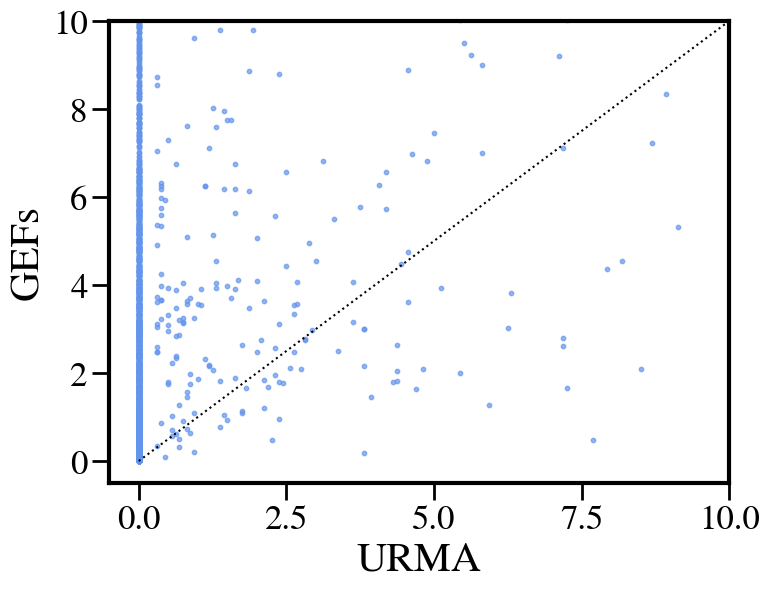

In [84]:
plt.scatter(np.where(a_at_stations<0.254, 0, a_at_stations), np.mean(gefs_apcp[0,:,:,0], axis=0), color='cornflowerblue', s=10,alpha=0.7)
plt.plot([0,60], [0,60], color='black', ls=':')
plt.xlim([-0.5,10])
plt.ylim([-0.5,10])
plt.xlabel('URMA')
plt.ylabel('GEFs')

In [78]:
from nimbl.metadata import get_metadata
conus_grid_def = get_metadata('grib2_section3', model='blend',region='co' )
conus_grid = grib2io.Grib2GridDef(conus_grid_def[4], conus_grid_def[5:])

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/nimbl/metadata/metadata.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metadata_df = pd.concat(collect, axis="index")


In [82]:
files = sorted(glob(f'/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/{start_day.strftime("%Y%m%d")}/gefs*.f96.APCP.24h'))
ds = xr.open_mfdataset(files, engine='grib2io', concat_dim ='perturbationNumber', combine='nested', parallel=False)
ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
ds_to_co = ds.grib2io.interp('bilinear', conus_grid)
gefs_precip = ds_to_co.APCP.data.compute()

In [85]:
np.shape(gefs_precip)

(30, 1597, 2345)

In [86]:
g_precip = gefs_precip[:,lat_idx, lon_idx]

Text(0, 0.5, 'GEFs')

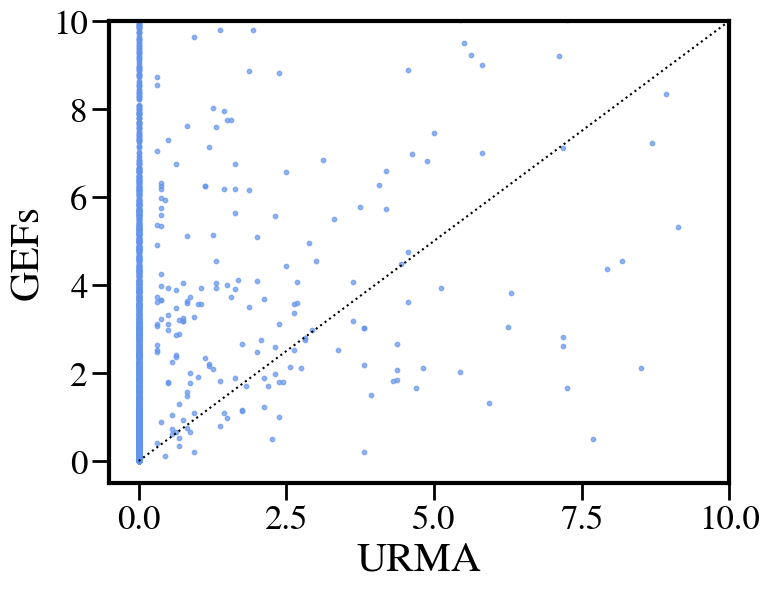

In [88]:
plt.scatter(np.where(a_at_stations<0.254, 0, a_at_stations), np.mean(g_precip, axis=0), color='cornflowerblue', s=10,alpha=0.7)
plt.plot([0,60], [0,60], color='black', ls=':')
plt.xlim([-0.5,10])
plt.ylim([-0.5,10])
plt.xlabel('URMA')
plt.ylabel('GEFs')

In [18]:
ds = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/data/gefs/supplemental_locations_QMD/20230505/gefs01.f96.APCP.24h', engine='grib2io')
ds_to_co = ds.grib2io.interp('bilinear', conus_grid_grib2)
precip_co = ds_to_co.APCP.data

In [17]:
porecip

<xarray.Dataset> Size: 75MB
Dimensions:                   (y: 1597, x: 2345)
Coordinates:
    refDate                   datetime64[ns] 8B ...
    leadTime                  timedelta64[ns] 8B ...
    valueOfFirstFixedSurface  float64 8B ...
    duration                  timedelta64[ns] 8B ...
    perturbationNumber        int64 8B ...
    validDate                 datetime64[ns] 8B ...
    longitude                 (y, x) float64 30MB -126.3 -126.3 ... -59.04
    latitude                  (y, x) float64 30MB 19.23 19.23 ... 54.38 54.37
Dimensions without coordinates: y, x
Data variables:
    APCP                      (y, x) float32 15MB 0.0 0.0 0.0 ... 1.373 1.396
Attributes:
    engine:            grib2io
    GRIB2IO_section3:  [        0   3744965         0         0        30    ...

In [16]:
ds_to_co.attrs['title'] = 

{'engine': 'grib2io',
 'GRIB2IO_section3': array([        0,   3744965,         0,         0,        30,         1,
                0,   6371200,       255,       255,       255,       255,
             2345,      1597,  19229000, 233723400,        48,  25000000,
        265000000,   2539703,   2539703,         0,        80,  25000000,
         25000000, -90000000,         0])}